In [ ]:
!gnom -h

In [ ]:
# Usage: gnom [OPTIONS] <FILE>

Indirect transform for SAS data processing -- evaluates the P(r)

Known Arguments:
  FILE                       Experimental data file

Known Options:
  -h, --help                 Print usage information and exit
  -v, --version              Print version information and exit
      --seed=<INT>           Set the seed for the random number generator
      --first=<N>            first point of the data file to use (default: 1)
      --last=<N>             last point of the data file to use (default: all)
      --system=<N>           system type, one of 0...6 (default: 0)
      --rmin=<VALUE>         minimum characteristic size of SYSTEM (default: 0.0)
      --rmax=<VALUE>          maximum characteristic size of SYSTEM (required)
      --rad56=<VALUE>        (no description)
      --force-zero-rmin=<Y|N>Zero condition at r=rmin (default: YES)
      --force-zero-rmax=<Y|N>Zero condition at r=rmax (default: YES)
      --nr=<N>               number of points in real space (default: automatic)
      --alpha=<VALUE>        alpha value (default: automatic)
  -o, --output=<FILE>        output file name (default: stdout)

Mandatory arguments to long options are mandatory for short options too.

Report bugs to <atsas@embl-hamburg.de>.

`gnom`に入力ファイルと最大長$Dmax$の予想値を入れてやると$P_{fit}(r)$関数が出力される。

In [ ]:
!gnom 6lyz.dat -rmax 50 -o 6lyz.out

In [ ]:
!head -n +60 "6lyz.out"

In [ ]:

           ####      G N O M             Version 5.0 (r12314)      ####
                                               Fri Apr 10 11:30:41 2020

           ####      Configuration                                 ####

            :
        　　略
            :

           ####      Results                                       ####

    Parameter    DISCRP  OSCILL  STABIL  SYSDEV  POSITV  VALCEN  SMOOTH
    Weight        1.000   3.000   3.000   3.000   1.000   1.000   1.000
    Sigma         0.300   0.600   0.120   0.120   0.120   0.120   0.600
    Ideal         0.700   1.100   0.000   1.000   1.000   0.950   0.000
    Current       0.003   1.349   0.002   0.100   1.000   0.947   0.103
               --------------------------------------------------------
    Estimate      0.005   0.842   1.000   0.000   1.000   0.999   0.971

    Angular range:                       0.0000 to       0.5000
    Reciprocal space Rg:             0.1536E+02
    Reciprocal space I(0):           0.2682E+03

    Real space range:                    0.0000 to      50.0000
    Real space Rg:                   0.1535E+02 +-   0.1278E+00
    Real space I(0):                 0.2682E+03 +-   0.1894E+01

    Highest ALPHA (theor):           0.4031E+06
    Current ALPHA:                   0.5615E-02

    Total Estimate:                      0.6538 (a REASONABLE solution)



           ####      Experimental Data and Fit                     ####

      S          J EXP       ERROR       J REG       I REG

   0.000000E+00   0.268216E+03   0.804647E+01   0.268197E+03   0.268197E+03
   0.250000E-02   0.268083E+03   0.804250E+01   0.268066E+03   0.268066E+03
   0.500000E-02   0.267688E+03   0.803065E+01   0.267671E+03   0.267671E+03
                        :
                        略
                        :
   0.492500E+00   0.138261E+01   0.414783E-01   0.138267E+01   0.138267E+01
   0.495000E+00   0.138138E+01   0.414414E-01   0.138123E+01   0.138123E+01
   0.497500E+00   0.138070E+01   0.414210E-01   0.138026E+01   0.138026E+01
   0.500000E+00   0.138052E+01   0.414157E-01   0.137969E+01   0.137969E+01

           ####      Real Space Data                               ####

           Distance distribution  function of particle  


      R          P(R)      ERROR

  0.0000E+00  0.0000E+00  0.0000E+00
  0.4464E+00  0.1602E-01  0.1713E-01
                :
                略
                :
  0.1607E+02  0.9318E+00  0.4651E-01
  0.1652E+02  0.9464E+00  0.5132E-01


上に表示されているのは、出力ファイル`6lyz.out`の中身の一部である。

これからもわかるように、ファイルは単純な構造をしておらず、最初にフィットパラメータ、次に散乱曲線とのフィット、最後にお目当ての$P(r)$関数が入っている。

必要な部分を`gnom`のoutputから抽出するpythonルーチンは、先程紹介した `shapes_module` の `read_pr` というメソッドを使用してもよいが、ここでは以下の筆者のコード `out_read` を紹介する。

In [1]:
def out_read(fn):
# input: file name (str)
# output: q,I_{exp}(q),sI_{exp}(q),I_{fit}(q),r,P(r),sP(r),Rg from P(r),I(0) from P(r)
# written by T.Fujisawa
#
    fin=open(fn,'r')
    lines = []
    for line in fin:
        #print line
        lines.append(line)
    npts=len(lines)
    j=0
    while j < npts:
        linet=lines[j]
        if 'Real space Rg:' in linet:
            a=linet.split(':')[-1]
            Rg_r=float(a.split('+-')[0])
            j=j+1
        elif 'Real space I(0):' in linet:
            a=linet.split(':')[-1]
            I0_r=float(a.split('+-')[0])
            j=j+1
        elif '      S          J EXP       ERROR       J REG       I REG' in linet:
            iqcash=[]
            j=j+2
            linet=lines[j]
            while 'Distance' not in linet:
                iqcash.append(linet)
                j=j+1
                linet=lines[j]            
            j=j+1
            linet=lines[j]
        elif '  R          P(R)      ERROR' in linet:
            prcash=[]
            j=j+1
            while j < npts-1:
                j=j+1
                linet=lines[j]
                prcash.append(linet)
        else:
            j=j+1
    
    ra=[]
    Pra=[]
    sPra=[]
    
    for line in prcash:
        rt=line[:14]
        Prt=line[15:26]
        sPrt=line[27:38]
        #if ('   ' not in iqt)or(qt!='n'):
        if rt.isspace():
            break
        if '#' in rt:
            continue
        elif '   ' not in Prt:
            ra.append(float(rt))
            Pra.append(float(Prt))
            sPra.append(float(sPrt))
    
    
    qe=[]
    iqe=[]
    siqe=[]
    iqm=[]
    for line in iqcash:
        qt=line[:17]
        iqt=line[18:32]
        siqt=line[33:47]
        iqmt=line[48:62]
        #if ('   ' not in iqt)or(qt!='n'):
        if qt.isspace():
            break
        if '#' in qt:
            continue
        elif '   ' not in iqt:
            #print iqt
            qe.append(float(qt))
            iqe.append(float(iqt))
            siqe.append(float(siqt))
            iqm.append(float(iqmt))
            
    
    return (qe,iqe,siqe,iqm,ra,Pra,sPra,Rg_r,I0_r)

上の関数`out_read`に`out`ファイルを入れてやると目的の情報を抽出してくれる。

In [2]:
q,I,sI,Im,r,Pr,sPr,Rg,I0=out_read('6lyz.out')

基本的にjupyter-notebookにおいては入力ファイルをnotebookファイルと同じディレクトリに入れておくものだが、ファイル名の打ち間違いなども
あるので筆者はGUIで処理するようにしている。pythonにおいてはデフォルトのGUI、`thkinter`を使用する。入力したファイル名はセルに出力するようにしておく。

上の実行例は以下のように変更すると使いやすくなる。

In [3]:
import tkinter
from tkinter import messagebox as tkMessageBox
from tkinter import filedialog as tkFileDialog
from tkinter import simpledialog as tkSimpleDialog

root=tkinter.Tk()
root.withdraw()

inFile=tkFileDialog.askopenfilename(title='Open GNOM file',filetypes=[("I(q) file","*.out")])
print("GNOM file:",inFile)
q,I,sI,Im,r,Pr,sPr,Rg,I0=out_read(inFile)


GNOM file: /media/fujisawa/2124879b-e9d4-4135-8fd5-9b114fd41989/home/backup/gifu_19/grad/SAXS_WG/report/source/M_M/6lyz.out


これで、`q`,`I`,`sI`,`Im`,`r`,`Pr`,`sPr`,`Rg`,`I0`　の情報が格納された。

`crysol` の時と同様、`pandas`にデータを格納してプロットをする。

必要なモジュールをインポートしておき、

In [4]:
%matplotlib inline
import pandas as pd
import shapes_module as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

まずは散乱曲線のフィットを`df`というデータフレームに変換する

In [5]:
df = pd.DataFrame({'q': q, 'I(q)': I,'error':sI,'I(q)_fit':Im})
df.head()

q     I(q)    error  I(q)_fit
0  0.0000  268.216  8.04647   268.197
1  0.0025  268.083  8.04250   268.066
2  0.0050  267.688  8.03065   267.671
3  0.0075  267.032  8.01095   267.014
4  0.0100  266.115  7.98344   266.098

同様に$P(r)$関数の方も`df2`というデータフレームに変換する。

In [6]:
df2 = pd.DataFrame({'r': r, 'P(r)': Pr,'Error':sPr})
df2.head()

r     P(r)    Error
0  0.0000  0.00000  0.00000
1  0.4464  0.01602  0.01713
2  0.8929  0.03216  0.02797
3  1.3390  0.04850  0.03289
4  1.7860  0.06513  0.03254

間接フーリエ変換の結果のチェックは$I(q)$のフィットの具合と$P(r)$の形などで判断するのでプロットをすると、

Text(0, 0.5, '$P(r)$')

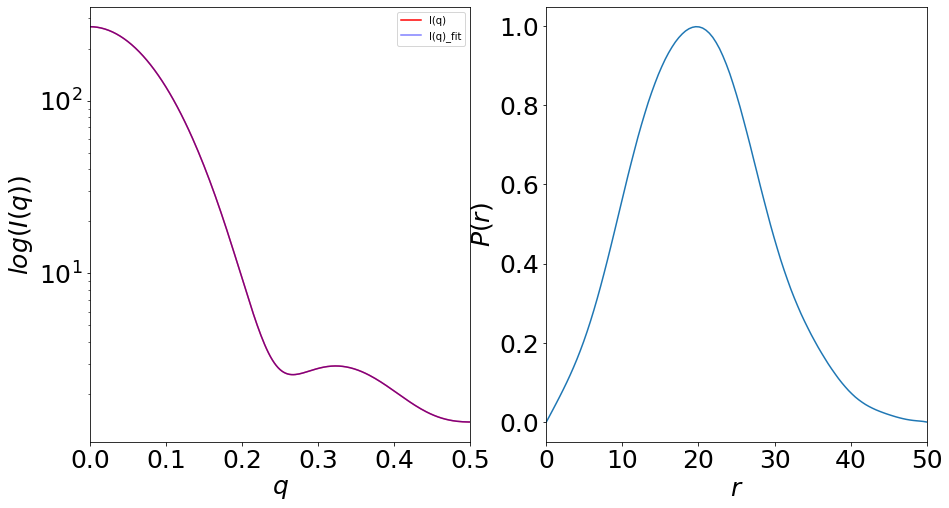

In [7]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
df.plot(ax=ax1,x='q',y='I(q)',color='red',label='I(q)',fontsize=25,logy=True)
df.plot(ax=ax1,x='q',y='I(q)_fit',color='blue',alpha=0.5,label='I(q)_fit',fontsize=25,logy=True)
ax1.set_xlabel('$q$',fontsize=25)
ax1.set_ylabel('$log(I(q))$',fontsize=25)

ax2 = fig.add_subplot(122)
df2.plot(ax=ax2, legend=False,x='r',y='P(r)',fontsize=25)
ax2.set_xlabel('$r$',fontsize=25)
ax2.set_ylabel('$P(r)$',fontsize=25)

#fig.savefig("gnom_plot.png")